In [68]:
# Upgrade environment to support TF 2.10 in Colab
!pip install -U --pre tensorflow tensorflow_datasets
!apt install --allow-change-held-packages libcudnn8=8.1.0.77-1+cuda11.2

Reading package lists... Done
Building dependency tree... Done
Reading state information... Done
Package libcudnn8 is not available, but is referred to by another package.
This may mean that the package is missing, has been obsoleted, or
is only available from another source

E: Version '8.1.0.77-1+cuda11.2' for 'libcudnn8' was not found


In [69]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models
from IPython import display

# Set the seed value for experiment reproducibility.
seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [70]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [71]:
DATASET_PATH = '/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/음성데이터'

data_dir = pathlib.Path(DATASET_PATH)
# if not data_dir.exists():
#   tf.keras.utils.get_file(
#       'mini_speech_commands.zip',
#       origin="http://storage.googleapis.com/download.tensorflow.org/data/mini_speech_commands.zip",
#       extract=True,
#       cache_dir='.', cache_subdir='data')

In [72]:
!pip install transformers

# 라벨링 질병 데이터 불러오기

In [73]:
import os

# 각 질병 폴더의 경로
disease_directories = [
    '/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/음성데이터/감기',
    '/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/음성데이터/결막염',
    '/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/음성데이터/위염'
]

# 각 질병 레이블과 해당 레이블에 대한 파일 목록을 저장할 딕셔너리 초기화
disease_files = {os.path.basename(directory): [] for directory in disease_directories}

# 각 질병 폴더를 순회하면서 해당 레이블에 대한 파일 목록을 수집
for directory in disease_directories:
    if os.path.isdir(directory):
        label = os.path.basename(directory)
        disease_files[label] = [filename for filename in os.listdir(directory) if filename.endswith('.wav')]

# 결과 출력
for label, files in disease_files.items():
    print(f'{label}: {len(files)} 파일')
    print(files)


감기: 59 파일
['PA_0016-133-01-03-M-09-A.wav', 'PA_0016-251-01-03-M-09-A.wav', 'PA_0016-334-01-03-M-09-A.wav', 'PA_0016-188-01-03-M-09-A.wav', 'PA_0016-33-01-03-M-09-A.wav', 'PA_0016-103-01-03-M-09-A.wav', 'PA_0016-377-01-03-M-09-A.wav', 'PA_0016-191-01-03-M-09-A.wav', 'PA_0016-232-01-03-M-09-A.wav', 'PA_0016-134-01-03-M-09-A.wav', 'PA_0016-218-01-03-M-09-A.wav', 'PA_0016-111-01-03-M-09-A.wav', 'PA_0016-326-01-03-M-09-A.wav', 'PA_0016-168-01-03-M-09-A.wav', 'PA_0016-63-01-03-M-09-A.wav', 'PA_0026-111-01-03-F-03-C.wav', 'PA_0026-218-01-03-F-03-C.wav', 'PA_0026-103-01-03-F-03-C.wav', 'PA_0026-33-01-03-F-03-C.wav', 'PA_0026-188-01-03-F-03-C.wav', 'PA_0026-326-01-03-F-03-C.wav', 'PA_0026-191-01-03-F-03-C.wav', 'PA_0026-63-01-03-F-03-C.wav', 'PA_0026-168-01-03-F-03-C.wav', 'PA_0026-251-01-03-F-03-C.wav', 'PA_0026-232-01-03-F-03-C.wav', 'PA_0026-134-01-03-F-03-C.wav', 'PA_0026-334-01-03-F-03-C.wav', 'PA_0026-377-01-03-F-03-C.wav', 'PA_0027-188-01-03-F-08-A.wav', 'PA_0027-218-01-03-F-08-A.wav', '

# 전처리- 스펙트로그램 이미지

In [74]:
import os
import librosa
import librosa.display
import matplotlib.pyplot as plt
import numpy as np

# 전처리된 스펙트로그램 이미지를 저장할 디렉토리 경로
output_directory = '/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지'

# 각 질병 레이블과 해당 레이블에 대한 파일 목록을 가져온다.
labels = list(disease_files.keys())
file_lists = list(disease_files.values())

# 이미지 크기 설정
image_width = 224  # 이미지의 너비
image_height = 224  # 이미지의 높이

# 스펙트로그램 이미지를 생성하고 저장
for label, files in zip(labels, file_lists):
    label_output_directory = os.path.join(output_directory, label)

    # 레이블에 해당하는 디렉토리가 없으면 생성
    os.makedirs(label_output_directory, exist_ok=True)

    for file in files:
        # 음성 파일 불러오기
        audio_path = os.path.join(disease_directories[labels.index(label)], file)
        audio, sr = librosa.load(audio_path, sr=16000)  # 1. 샘플링 레이트 16kHz로 조정

        # 무음 부분을 제거하여 음성 데이터를 전처리
        trimmed_audio, _ = librosa.effects.trim(audio, top_db=20)  # 무음 부분 자르기 (예: top_db=20은 -20dB 미만의 소리를 무음으로 간주)

        # 음성 신호 정규화
        trimmed_audio = trimmed_audio / np.max(np.abs(trimmed_audio))  # 2. 음성 신호 정규화

        # 스펙트로그램 생성
        spectrogram = librosa.feature.melspectrogram(y=audio, sr=sr)
        log_spectrogram = librosa.power_to_db(spectrogram, ref=np.max)

        # 스펙트로그램 이미지 생성 및 저장
        plt.figure(figsize=(5, 5))
        librosa.display.specshow(log_spectrogram, sr=sr)
        plt.axis('off')  # 축 제거
        output_path = os.path.join(label_output_directory, f'{os.path.splitext(file)[0]}.png')
        plt.savefig(output_path, bbox_inches='tight', pad_inches=0, transparent=True)
        plt.close()

        print(f'{output_path} 저장 완료.')

print('스펙트로그램 이미지 생성 및 저장 완료.')


/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-133-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-251-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-334-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-188-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-33-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-103-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-377-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-191-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지/감기/PA_0016-232-01-03-M-09-A.png 저장 완료.
/content/drive/MyDrive/Colab Notebooks/데이터분석/[미

스펙트로그램 이미지로 전처리하는 이유는 음성 데이터를 기계 학습 모델에 입력으로 사용하기 위해서입니다. 일반적인 딥러닝 모델(예: CNN 또는 **Transformer**)은 이미지 데이터를 처리하는 데 효과적으로 설계되어 있으므로, 음성 데이터를 이미지 형태로 변환하여 이러한 모델에 제공하는 것이 일반적입니다.

스펙트로그램 이미지로의 변환은 다음과 같은 이점을 제공합니다:

시각적 정보 포착: 스펙트로그램 이미지는 음성 신호의 주파수 및 시간 정보를 시각적으로 표현합니다. 이것은 모델에게 시간 및 주파수 도메인에서의 특징을 파악하고 패턴을 학습하는 데 도움이 됩니다.

이미지 처리 모델 활용: 이미지 처리에 특화된 딥러닝 모델(예: CNN)을 사용할 수 있습니다. 이 모델들은 이미지 데이터를 처리하기 위해 설계되었으며, 스펙트로그램 이미지는 이러한 모델에 잘 맞습니다.

데이터 정규화: 스펙트로그램 이미지를 생성할 때, 주로 정규화 기술을 사용하여 데이터의 크기를 조정합니다. 이로써 모델이 데이터의 스케일에 민감하지 않고 안정적으로 학습할 수 있습니다.

데이터 차원 일치: 스펙트로그램 이미지는 2D 형태이므로, 모델의 입력 데이터 차원과 잘 일치합니다. 이를 통해 모델 구성이 간단해지고 효율적인 학습이 가능합니다.

따라서 스펙트로그램 이미지로 전처리하는 것은 음성 데이터를 기계 학습 모델에 적용하기 위한 일반적인 방법 중 하나이며, 음성 데이터의 시각적 특징을 캡처하여 음성 처리 및 분류 작업에 도움을 줍니다.

# 스펙트럼 이미지 데이터 로드 및 데이터 split:

In [75]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import transforms, datasets
from sklearn.model_selection import train_test_split
from tqdm import tqdm

In [76]:
import os
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense

# 스펙트로그램 이미지가 있는 디렉터리
image_directory = '/content/drive/MyDrive/Colab Notebooks/데이터분석/[미니프로젝트]/질병/스펙트로그램이미지'

# 이미지 파일 경로와 해당하는 레이블을 저장할 리스트
image_paths = []
labels = []

# 각 하위 디렉터리를 반복 (각각은 레이블에 해당)
for label in os.listdir(image_directory):
    label_dir = os.path.join(image_directory, label)

    # 하위 디렉터리 내의 이미지 파일을 반복
    for image_file in os.listdir(label_dir):
        image_path = os.path.join(label_dir, image_file)

        # 이미지 경로와 해당 레이블을 리스트에 추가
        image_paths.append(image_path)
        labels.append(label)

# 데이터를 훈련 및 검증 세트로 분할
X_train, X_val, y_train, y_val = train_test_split(image_paths, labels, test_size=0.2, random_state=42)

# 레이블을 정수로 매핑하는 딕셔너리 생성
label_to_int = {label: idx for idx, label in enumerate(np.unique(labels))}
int_to_label = {idx: label for label, idx in label_to_int.items()}

# 레이블을 정수로 변환
y_train = np.array([label_to_int[label] for label in y_train])
y_val = np.array([label_to_int[label] for label in y_val])

# 이미지를 전처리하는 함수 정의
def preprocess_image(image_path):
    # 이미지를 로드하고 전처리
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(image_width, image_height))
    img = tf.keras.preprocessing.image.img_to_array(img)
    img = img / 255.0  # 픽셀 값을 [0, 1] 범위로 정규화
    return img

# 훈련 및 검증 데이터를 전처리
X_train = [preprocess_image(image_path) for image_path in X_train]
X_val = [preprocess_image(image_path) for image_path in X_val]

# 리스트를 NumPy 배열로 변환
X_train = np.array(X_train)
X_val = np.array(X_val)


# 데이터 전처리 및 모델 훈련:



In [78]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers


1차 : batch_size = 32, epochs = 10, Test accuracy: 40.62%

2차 : batch_size = 64, epochs = 20, Test accuracy: 43.75%

3차 : batch_size = 128, epochs = 40,Test accuracy: 46.88%

4차 : batch_size = 256, epochs = 80,Test accuracy: 50.00%

5차 : batch_size = 256, epochs = 40,Test accuracy: 34.38%

6차 : batch_size = 256, epochs = 160,Test accuracy: 40.62%

7차 : batch_size = 512, epochs = 80,Test accuracy: 34.38%

8차 : batch_size = 256, epochs = 60,Test accuracy: 37.50%

9차 : batch_size = 256, epochs = 85,Test accuracy: 40.62%

10차 : batch_size = 256, epochs = 80,Test accuracy: 40.62%

11차 : batch_size = 128, epochs = 80,Test accuracy: 37.50%

12차 : batch_size = 16, epochs = 40,Test accuracy: 40.62%

13차 : batch_size = 8, epochs = 20,Test accuracy: 31.25%

14차 : batch_size = 32, epochs = 80,Test accuracy: 34.38%

15차 : batch_size = 256, epochs = 90,Test accuracy: 46.88%

16차 : batch_size = 256, epochs = 180,Test accuracy: 40.62%

17차 : batch_size = 512, epochs = 180,Test accuracy: 40.62%

18차 : batch_size = 256, epochs = 80,Test accuracy: 46.88%

19차 : batch_size = 300, epochs = 80,Test accuracy: 40.62%

20차 : batch_size = 256, epochs = 80,Test accuracy: 37.50%

21차 : batch_size = 100, epochs = 10,Test accuracy: 31.25%

22차 : batch_size = 256, epochs = 5,Test accuracy: 40.62%

23차 : batch_size = 128, epochs = 5,Test accuracy: 25.00%

24차 : batch_size = 64, epochs = 10,Test accuracy: 37.50%

25차 : batch_size = 64, epochs = 30,Test accuracy: 43.75%

26차 : batch_size = 64, epochs = 60,Test accuracy: 43.75%

27차 : batch_size = 128, epochs = 60,Test accuracy: 40.62%

28차 : batch_size = 64, epochs = 45,Test accuracy: 37.50%

29차 : batch_size = 256, epochs = 80,Test accuracy: 37.50%, Conv2D(64->32>32>Dense32)

30차 : batch_size = 256, epochs = 80,Test accuracy: 40.62%, Conv2D(32->16>8>Dense4)

31차 : batch_size = 256, epochs = 80,Test accuracy: 34.38%, Conv2D(16->8>Dense4)

32차 : batch_size = 256, epochs = 80,Test accuracy: 50.00%, Conv2D(32->64>128>64>Dense32)







In [195]:
# 모델 정의
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(image_width, image_height, 3)),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D((2, 2)),
    Conv2D(64, (3, 3), activation='relu'),
    Flatten(),
    Dense(32, activation='relu'),
    Dense(len(label_to_int), activation='softmax')  # 클래스 수는 레이블 수에 따라 설정
])

# 모델 컴파일
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

# 모델 요약 출력
model.summary()

# 모델 훈련
batch_size = 256
epochs = 80


history = model.fit(X_train, y_train, batch_size=batch_size, epochs=epochs, validation_data=(X_val, y_val))

Model: "sequential_40"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 222, 222, 32)      896       
                                                                 
 max_pooling2d_81 (MaxPooli  (None, 111, 111, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_122 (Conv2D)         (None, 109, 109, 64)      18496     
                                                                 
 max_pooling2d_82 (MaxPooli  (None, 54, 54, 64)        0         
 ng2D)                                                           
                                                                 
 conv2d_123 (Conv2D)         (None, 52, 52, 128)       73856     
                                                                 
 max_pooling2d_83 (MaxPooli  (None, 26, 26, 128)     

# 모델 평가:



In [196]:
# 모델 평가
test_loss, test_accuracy = model.evaluate(X_val, y_val, verbose=2)
print(f"Test accuracy: {test_accuracy*100:.2f}%")


1/1 - 0s - loss: 7.4012 - accuracy: 0.5000 - 47ms/epoch - 47ms/step
Test accuracy: 50.00%


# 하이퍼파라미터 조정

# 모델 저장

In [192]:
# 모델 저장
model.save('my_model.h5')


# 모델 불러오기

In [193]:
from tensorflow.keras.models import load_model

# 모델 불러오기
loaded_model = load_model('my_model.h5')

# 시각화

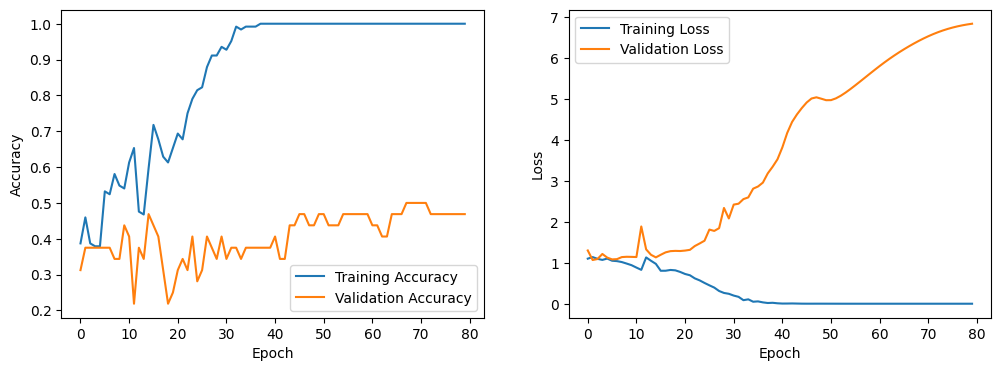

In [194]:
# 훈련 결과 시각화
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()